The following notebook contains necessary steps to recreate the result provided in the accompanying manuscript. Where required, please refer to the source code provided in the [github page](https://github.com/lehai-ml/dHCP_genetics) and the [nimagen package](https://github.com/lehai-ml/nimagen)

Resources used in this paper:

- developing Human Connectome Project (3rd Release) : https://biomedia.github.io/dHCP-release-notes/
- preprocessed genetic data (individual genetic data, polygenic risk score, ancestry PCs): please contact author regarding availability
- MSigDB database custom build: https://www.gsea-msigdb.org/gsea/msigdb (accession date 27 Jan 2022)
- The Human Genome Build 37: https://ctg.cncr.nl/software/magma (accession date 3 Feb 2022)
- FUMA: overrepresentation analyis was adapted from FUMA python source code to enable the random simulation


All visualisation used in this paper can be done using the [nimagen package](https://github.com/lehai-ml/nimagen) visualisation function and seen in the following notebook

In [1]:
# Importing the necessary packages
import sys
sys.path.append('../../')
sys.path.append('../')

import pandas as pd
import numpy as np

from codes.docs.analysis.nimagen import stats, visualisation, graph,genes
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from IPython.display import display, Image, Markdown
%matplotlib inline

# Primary PRS-volume analysis

The first two rows of the imaging dataframe

,ID,Session,TBV,ICV,CSF,GM,WM,Background,Ventricles,Cerebellum,...,ASD_PRS_Pt_1e-07,ASD_PRS_Pt_1e-06,ASD_PRS_Pt_1e-05,ASD_PRS_Pt_0.0001,ASD_PRS_Pt_0.001,ASD_PRS_Pt_0.01,ASD_PRS_Pt_0.05,ASD_PRS_Pt_0.1,ASD_PRS_Pt_0.5,ASD_PRS_Pt_1
0,CC00749XX24,2600,422755.875,516267.250,89299.500,186431.125,159458.500,42253.5,4211.875,34543.375,...,-0.068172,0.001457,0.014132,-0.003923,-0.003222,-0.002080,-0.001829,-0.001661,-0.001067,-0.000823
1,CC00803XX11,2700,339311.375,426793.875,71507.125,142816.500,137087.375,41193.5,15975.375,24617.375,...,-0.064572,-0.009543,0.008322,-0.005172,-0.002964,-0.002129,-0.001704,-0.001572,-0.001032,-0.000796


The european volumetric dataframe has **293** individuals, of whom **14** are excluded because of low radiology score (i.e., radiology_score = 5 and radiology_low_image_quality = True)

Of the remaining **279** individuals, we check pairwise ancestral PC to reveal european ancestry outliers

Example below show 2 outliers when plotting the PC2 and PC3 in the lower left corner.


This process yielded **273** individuals

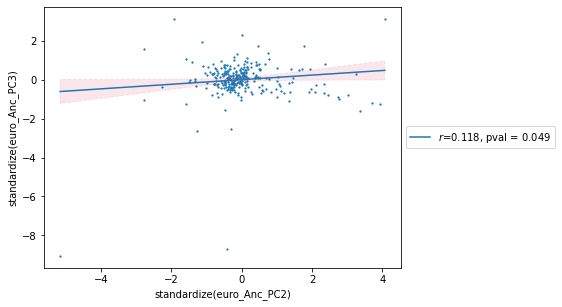

In [137]:
%matplotlib inline
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

display(Markdown('The first two rows of the imaging dataframe'))
display(european_volumetric_dataset_term.head(2))
display(Markdown(r'The european volumetric dataframe has **{}** individuals, of whom **{}** are excluded because of low radiology score (i.e., radiology_score = 5 and radiology_low_image_quality = True)'.format(european_volumetric_dataset_term.shape[0],european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']==5)|(european_volumetric_dataset_term['radiology_low_image_quality']==True)].shape[0])))

european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

display(Markdown(rf"""Of the remaining **{european_volumetric_dataset_term.shape[0]}** individuals, we check pairwise ancestral PC to reveal european ancestry outliers

Example below show 2 outliers when plotting the PC2 and PC3 in the lower left corner.
"""))

df = european_volumetric_dataset_term.copy()
ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers


visualisation.SimplePlots.Scatter(
x=ancestry[1],y=ancestry[2],
data=df)

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1,)

df = df.drop(columns=['ASD_PRS_Pt_1e-07'])


display(Markdown(rf"""This process yielded **{df.shape[0]}** individuals"""))



Then we performed PCA on the available PRS, we found that the first PC explained 44.0 \% of the total variability

The PRS-PC1 appears to be in the positive direction with individual P_T

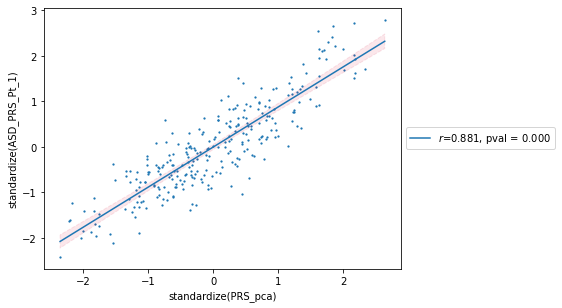

In [138]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

df['PRS_pca'] = prs_pca

display(Markdown(r"""Then we performed PCA on the available PRS, we found that the first PC explained {} \% of the total variability

The PRS-PC1 appears to be in the positive direction with individual P_T""".format(round(pca['pca'].explained_variance_ratio_[0],2)*100)))

visualisation.SimplePlots.Scatter(y=['ASD_PRS_Pt_1'],
                                  x=['PRS_pca'],
                                 data=df)

Of the 87 brain volumes, we selected only the ones that contribute to the 4 lobes (i.e., only cortical WM and GM)

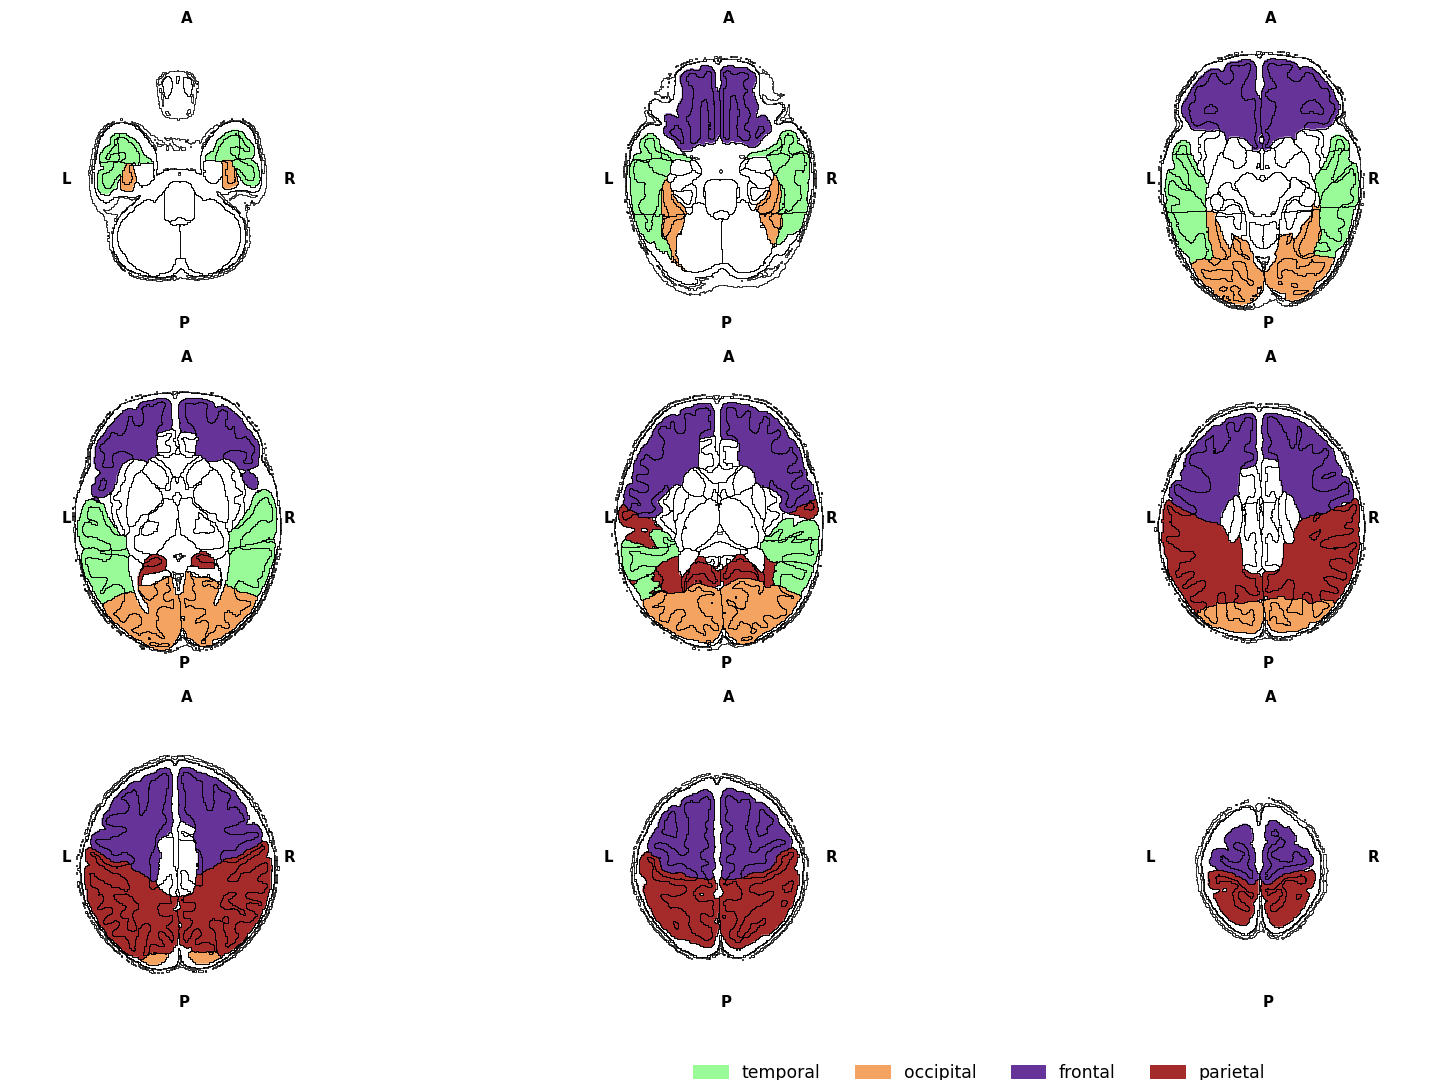

In [139]:
display(Markdown(r'Of the 87 brain volumes, we selected only the ones that contribute to the 4 lobes (i.e., only cortical WM and GM)'))
display(Image('../../../nimagen/docs/example/images/brain_legend_full.png'))

new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'])

new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 15']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']

new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']

In [158]:
model,euro_univariate_result = stats.MassUnivariate.mass_univariate(new_df,
                                           cat_independentVar_cols=['sex'],
                                           cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
                                           dependentVar_cols=[i for i in new_df.columns if 'TTV' in i])

display(Markdown(r"""
Performing mass univariate tests as follows:

$Volume = sex + PRS_{pca} + GA + PMA + TBV + AncPCs$ , where volume are 6 brain lobe volumes: Frontal, fronto-temporal, Temporal, Parietal, parieto-occpital, Occipital.

FDR was selected to account for multiple testing correction. Below shows the 4 phenotypes that showed statistically significance association between PRS pca and Imaging volume.

"""))
display(stats.MultipleCorrection.fdr(euro_univariate_result,p_val="standardize(Q('PRS_pca'))_pval").sort_values(by="standardize(Q('PRS_pca'))_pval"))


Performing mass univariate tests as follows:

$Volume = sex + PRS_{pca} + GA + PMA + TBV + AncPCs$ , where volume are 6 brain lobe volumes: Frontal, fronto-temporal, Temporal, Parietal, parieto-occpital, Occipital.

FDR was selected to account for multiple testing correction. Below shows the 4 phenotypes that showed statistically significance association between PRS pca and Imaging volume.



,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,adjP
Frontal+Temporal TTV,164211.269012,0.0,283.856601,0.495525,533.972976,0.004757,91.118372,0.704102,-2162.472638,4.611104e-09,22934.768924,2.358900e-178,12.707629,0.946765,-442.064665,0.019974,209.194773,0.270192,0.018566
Parietal+Occipital TTV,120615.863662,0.0,358.190802,0.428311,-561.891475,0.006189,304.364451,0.243118,167.199456,6.662493e-01,16387.613969,9.555583e-134,-70.571157,0.732706,269.368038,0.189982,-74.106663,0.718720,0.018566
Parietal lobe TTV,73575.067072,0.0,91.217390,0.800802,-376.058970,0.021709,221.582307,0.287975,140.504584,6.504764e-01,9561.862551,2.065569e-102,-83.802373,0.612191,240.429168,0.143771,-145.323702,0.377538,0.040753
Frontal lobe TTV,113761.933725,0.0,159.608648,0.704292,420.799035,0.027169,161.998453,0.503926,-2049.925434,3.369896e-08,16296.302743,1.168377e-140,117.363122,0.541645,-322.264974,0.092270,250.563794,0.191233,0.040753


# Exploratory gene-set enrichment analysis

In [70]:
snp_file = pd.read_table('../../dataset/SNPs/asd/ASD.snp') # the snps used to generate individual PRS
best_SNPs=genes.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=1.)

display(Markdown(rf"""Exploratory gene set analysis was employed to examine the if individual SNPs that contribute to the PRS-PC1 converged on any relevant biological pathway. Here, the workflow is as follows:

1. Perform univariate test for each SNP (**{snp_file.shape[0]}** SNPs) to assess its effect on either parieto-occipital and fronto-temporal brain volume. The formula is the same as above.
2. Setting the Pvalue threshold = 0.01, group the SNPs into those associated only with fronto-temporal brain volume , those associated with only parieto-occipital brain volume, those associated with both volumes.
3. Assign each of the SNP to a gene and generate 3 gene list corresponding to the 3 SNPs subset.
4. Perform overrepresentation analysis on the 3 gene list.
5. Perform random analysis

"""))

# uncomment this to line to run the univariate test command. The result of the univariate is saved i
best_SNPs_annot = genes.SNPsFunctionalAnalysis(snps_list=best_SNPs.SNP.to_list(),
                                                bed_file=f'../../dataset/genetic_dataset/target_files/batch2/euro_batch2_genotyped.bed')

# new_df['FID'] = new_df['IID'] = new_df['ID']
# new_df['sex_dummy'] = [1 if i == 'female' else 0 for i in new_df['sex']]

# new_df[['FID','IID','Frontal+Temporal TTV','Parietal+Occipital TTV']].to_csv('../../dataset/genetic_dataset/pheno_cov_files/asd/phenotype_EUR.txt',index=False,sep='\t')
# new_df[['FID','IID']+ancestry+['TBV','GA','PMA','sex_dummy']].to_csv('../../dataset/genetic_dataset/pheno_cov_files/asd/covariate_EUR.txt',index=False,sep='\t')

# updated_bed_file,best_SNPs_annot.snp_association = best_SNPs_annot.do_mass_univariate_test(
#     orig_bed_file=best_SNPs_annot.orig_bed_file,
#     snps_list=best_SNPs_annot.snps_list,
#     pheno_file=
#     f'../../dataset/genetic_dataset/pheno_cov_files/asd/phenotype_EUR.txt',
#     covar_file=
#     f'../../dataset/genetic_dataset/pheno_cov_files/asd/covariate_EUR.txt',
#     phenotype="Parietal+Occipital TTV",
#     updated_bed_file=updated_bed_file) # change the phenotype argument to Frontal+Temporal TTV
# best_SNPs_annot.snp_association.to_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/parieto_occipital_snp.csv',index=False)

Exploratory gene set analysis was employed to examine the if individual SNPs that contribute to the PRS-PC1 converged on any relevant biological pathway. Here, the workflow is as follows:

1. Perform univariate test for each SNP (**116433** SNPs) to assess its effect on either parieto-occipital and fronto-temporal brain volume. The formula is the same as above.
2. Setting the Pvalue threshold = 0.01, group the SNPs into those associated only with fronto-temporal brain volume , those associated with only parieto-occipital brain volume, those associated with both volumes.
3. Assign each of the SNP to a gene and generate 3 gene list corresponding to the 3 SNPs subset.
4. Perform overrepresentation analysis on the 3 gene list.
5. Perform random analysis



In [3]:
PO_SNPs_univar = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/parieto_occipital_snp.csv')
FT_SNPs_univar = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/fronto_temporal_snp.csv')
combined_SNPs_univar = pd.merge(PO_SNPs_univar,FT_SNPs_univar,on=['SNP','A1'],suffixes=['_PO','_FT'])

PO_best_SNPs = combined_SNPs_univar[(combined_SNPs_univar['P_PO']<0.01)&(combined_SNPs_univar['P_FT']>0.01)].copy()
FT_best_SNPs = combined_SNPs_univar[(combined_SNPs_univar['P_FT']<0.01)&(combined_SNPs_univar['P_PO']>0.01)].copy()
both_best_SNPs = combined_SNPs_univar[(combined_SNPs_univar['P_PO']<0.01)&(combined_SNPs_univar['P_FT']<0.01)].copy()

both_best_SNPs_genes_ID, both_best_SNPs_snp_ID = best_SNPs_annot.SNPs_annotation_to_gene(
    snps_list=both_best_SNPs.SNP.tolist(),
    gene_build_path=
    f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
    window_size=0)

FT_best_SNPs_genes_ID, FT_best_SNPs_snp_ID = best_SNPs_annot.SNPs_annotation_to_gene(
    snps_list=FT_best_SNPs.SNP.tolist(),
    gene_build_path=
    f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
    window_size=0)

PO_best_SNPs_genes_ID, PO_best_SNPs_snp_ID = best_SNPs_annot.SNPs_annotation_to_gene(
    snps_list=PO_best_SNPs.SNP.tolist(),
    gene_build_path=
    f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
    window_size=0)

In [4]:
display(Markdown(rf"""
Performing univariate test, we identified: 

1. {PO_best_SNPs.shape[0]} SNPs were associated only with PO lobe volume, which mapped to {PO_best_SNPs_genes_ID.shape[0]} genes
2. {FT_best_SNPs.shape[0]} SNPs were associated only with FT lobe volume, which mapped to {FT_best_SNPs_genes_ID.shape[0]} genes
3. {both_best_SNPs.shape[0]} SNPs were associated with both lobe volumes, which mapped to {both_best_SNPs_genes_ID.shape[0]} genes

ORA was then performed on each of the 3 gene lists

"""))

# uncomment the following lines to run the ORA.
msigdb_dataset ='../../dataset/genetic_dataset/pathway_database/MSigDB/MSigDB_custom_entrez.gmt'
background_gene = '../../dataset/genetic_dataset/gene_build/NCBI37_gene_loc.txt'
gene_job = f'../../dataset/preprocessed_dataset/asd/snp_wise_univariate/FT_PO_common_genes.txt'
# PO_res = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,PO_best_SNPs_genes_ID.Gene_ID.tolist(),disable_tqdm=False)

#FT_res = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,FT_best_SNPs_genes_ID.Gene_ID.tolist(),disable_tqdm=False)

#both_res = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,both_best_SNPs_genes_ID.Gene_ID.tolist(),disable_tqdm=False)





Performing univariate test, we identified: 

1. 925 SNPs were associated only with PO lobe volume, which mapped to 346 genes
2. 937 SNPs were associated only with FT lobe volume, which mapped to 356 genes
3. 216 SNPs were associated with both lobe volumes, which mapped to 84 genes

ORA was then performed on each of the 3 gene lists



In [5]:
FT_res = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/FT_ora.csv',sep='\t')
PO_res = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/PO_ora.csv',sep='\t')
both_res = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/both_ora.csv',sep='\t')

display(Markdown(rf"""
Using the p-value threshold of {round(0.05/13159/3,10)} (i.e., 0.05/3/13159) we found

Enriched pathways with FT volume
"""))

display(FT_res[FT_res['adjP']<0.05/3])
display(Markdown(r'Enriched pathways with PO volume'))
display(PO_res[PO_res['adjP']<0.05/3])
display(Markdown(r'Enriched pathways with both volumes'))
display(both_res[both_res['adjP']<0.05/3])


Using the p-value threshold of 1.2666e-06 (i.e., 0.05/3/13159) we found

Enriched pathways with FT volume


,GeneSet,N_genes,N_overlap,p,genes,adjP
4984,GOBP_BIOLOGICAL_ADHESION,1477,54,8.205094e-07,84966:9473:1600:57554:257194:5362:3914:27185:8...,0.010797


Enriched pathways with PO volume

,GeneSet,N_genes,N_overlap,p,genes,adjP
4984,GOBP_BIOLOGICAL_ADHESION,1477,54,3.276681e-07,63036:10451:7143:7399:88:9378:129684:23671:107...,0.004312
11029,GOCC_NEURON_PROJECTION,1330,52,6.928891e-08,9249:23266:23566:7399:88:6335:6772:92737:6295:...,0.000912
11092,GOCC_SYNAPSE,1298,49,4.933547e-07,23566:7143:7399:88:9378:81615:2066:6529:8618:1...,0.006492
11218,GOCC_SYNAPTIC_MEMBRANE,371,22,9.501241e-07,9378:2066:6529:2560:287:23345:1607:3092:4897:9...,0.012503


Enriched pathways with both volumes

,GeneSet,N_genes,N_overlap,p,genes,adjP
5034,GOBP_NEURON_DIFFERENTIATION,1338,20,7.646551e-07,1600:57142:9394:152330:7155:1608:3516:57451:26...,0.010062


In [6]:
display(Markdown(r"""Random simulation was then generated for each of the gene list to ensure that the pathways identified were indeed specific to the phenotypes of interest (i.e., remember we selected SNPs associated with the imaging phenotypes using p-value < 0.01). 
                 
Here, we randomly sampled ***N*** number of SNPs, where ***N*** is the same number of SNP found in each gene list. Then we generated the gene list corresponded to that random SNP subset and performed ORA on that gene list. We record the most associated pathway in each run. We repeat this 1000 times. And we set the pathway specific to our imaging phenotype of interest is the one that is found in less than 5% of the time.

The rationale is that the pathways specific to the imaging phenotype will not contain the same set of SNPs as if we were to select them in random """))




Random simulation was then generated for each of the gene list to ensure that the pathways identified were indeed specific to the phenotypes of interest (i.e., remember we selected SNPs associated with the imaging phenotypes using p-value < 0.01). 
                 
Here, we randomly sampled ***N*** number of SNPs, where ***N*** is the same number of SNP found in each gene list. Then we generated the gene list corresponded to that random SNP subset and performed ORA on that gene list. We record the most associated pathway in each run. We repeat this 1000 times. And we set the pathway specific to our imaging phenotype of interest is the one that is found in less than 5% of the time.

The rationale is that the pathways specific to the imaging phenotype will not contain the same set of SNPs as if we were to select them in random 

In [7]:
# The following functions are used to generate random simulation. Change the sample number and output directory.

def create_random_genesets(job):
    random_SNPs = best_SNPs.sample(216) # change the number here- PO volume - 925, FT - 936, both -216 SNPs.
    random_SNPs_annot = genes.SNPsFunctionalAnalysis(
        snps_list=random_SNPs.SNP.to_list(),
        bed_file=
        '../../dataset/genetic_dataset/target_files/batch2/euro_batch2_genotyped.bed'
    )
    random_SNPs_annot.genes_ID, random_SNPs_annot.snp_ID = random_SNPs_annot.SNPs_annotation_to_gene(
        snps_list=random_SNPs.SNP.tolist(),
        gene_build_path=
        f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
        window_size=0)
    random_SNPs_annot.genes_ID[['Gene_ID']].to_csv(
        f'../../dataset/preprocessed_dataset/asd/snp_wise_univariate/random/common/random_genes_all{job}.txt', # change the output directory here
        header=False,
        index=False,
        sep=' ')
    
def generate_best_enriched_path(job):
    msigdb_dataset ='../../dataset/genetic_dataset/pathway_database/MSigDB/MSigDB_custom_entrez.gmt'
    background_gene = '../../dataset/genetic_dataset/gene_build/NCBI37_gene_loc.txt'
    gene_job = f'../../dataset/preprocessed_dataset/asd/snp_wise_univariate/random/common/random_genes_all{job}.txt'
    res = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,gene_job,disable_tqdm=True)
    res['run'] = job
    res = res.sort_values(by='adjP')
    output_file = '../../dataset/preprocessed_dataset/asd/snp_wise_univariate/random/common/random_enriched_paths.csv' # change the output directory here
    if not os.path.isfile(output_file):
        res.head(3).to_csv(output_file, header='column_names')
    else: # else it exists so append without writing the header
        res.head(3).to_csv(output_file, mode='a', header=False)
        
#uncomment the following lines to perform the random simulation
# start=time.time()
# tasks = [delayed(create_random_genesets)(i) for i in range(1000)]
# Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
# end = time.time()
# print((end-start))      

In [28]:
PO_random = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/random/PO_unique/random_enriched_paths.csv')
PO_random = PO_random.groupby('run').head(1)
PO_random = pd.DataFrame(PO_random.GeneSet.value_counts())
PO_random = PO_random[PO_random['GeneSet']>50]


both_random = pd.read_csv('../../dataset/preprocessed_dataset/asd/snp_wise_univariate/random/common/random_enriched_paths.csv')
both_random = both_random.groupby('run').head(1)
both_random = pd.DataFrame(both_random.GeneSet.value_counts())
both_random = both_random[both_random['GeneSet']>50]

display(Markdown(r"""
Running the random simulations, we found by selecting random 925 SNPs (same number as the number of SNPs in SNPs subset most associated with PO volume), the following pathways are most enriched 
"""))

display(PO_random)

display(Markdown(r"""
By selecting random 216 SNPs (same number as the number of SNPs in SNPs subset most associated with both volumes), the following pathways are most enriched.
"""))

display(both_random)




Running the random simulations, we found by selecting random 925 SNPs (same number as the number of SNPs in SNPs subset most associated with PO volume), the following pathways are most enriched 


,GeneSet
GOCC_SYNAPSE,239
GOCC_NEURON_PROJECTION,98
GOBP_BIOLOGICAL_ADHESION,88
GOBP_NEURON_DEVELOPMENT,71
GOBP_NEUROGENESIS,65
GOBP_CELL_MORPHOGENESIS,53



By selecting random 216 SNPs (same number as the number of SNPs in SNPs subset most associated with both volumes), the following pathways are most enriched.


,GeneSet
BIOCARTA_GRANULOCYTES_PATHWAY,194


In [101]:
display(Markdown(r'Together, our result indicates that of the enriched pathways associated with the phenotypes of interests, **Synaptic Membrane** was specific to the PO_volume, and **Neuron differentiation** with both volumes.'))
specific_results = pd.concat([PO_res[PO_res['GeneSet']=='GOCC_SYNAPTIC_MEMBRANE'],
           both_res[both_res['GeneSet']=='GOBP_NEURON_DIFFERENTIATION']])
specific_results['Proportion'] = specific_results['N_overlap']/specific_results['N_genes']
gene_to_name = pd.read_csv('../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',sep='\t',header=None,usecols=[0,5],names=['Gene_ID','NAME']).set_index('Gene_ID').to_dict()['NAME']
specific_results['genes_names'] = specific_results['genes'].apply(lambda x: ':'.join([gene_to_name[int(i)] for i in x.split(':')]))

display(specific_results)

Together, our result indicates that of the enriched pathways associated with the phenotypes of interests, **Synaptic Membrane** was specific to the PO_volume, and **Neuron differentiation** with both volumes.

,GeneSet,N_genes,N_overlap,p,genes,adjP,Proportion,genes_names
11218,GOCC_SYNAPTIC_MEMBRANE,371,22,9.501241e-07,9378:2066:6529:2560:287:23345:1607:3092:4897:9...,0.012503,0.059299,NRXN1:ERBB4:SLC6A1:GABRB1:ANK2:SYNE1:DGKB:HIP1...
5034,GOBP_NEURON_DIFFERENTIATION,1338,20,7.646551e-07,1600:57142:9394:152330:7155:1608:3516:57451:26...,0.010062,0.014948,DAB1:RTN4:HS6ST1:CNTN4:TOP2B:DGKG:RBPJ:TENM2:A...


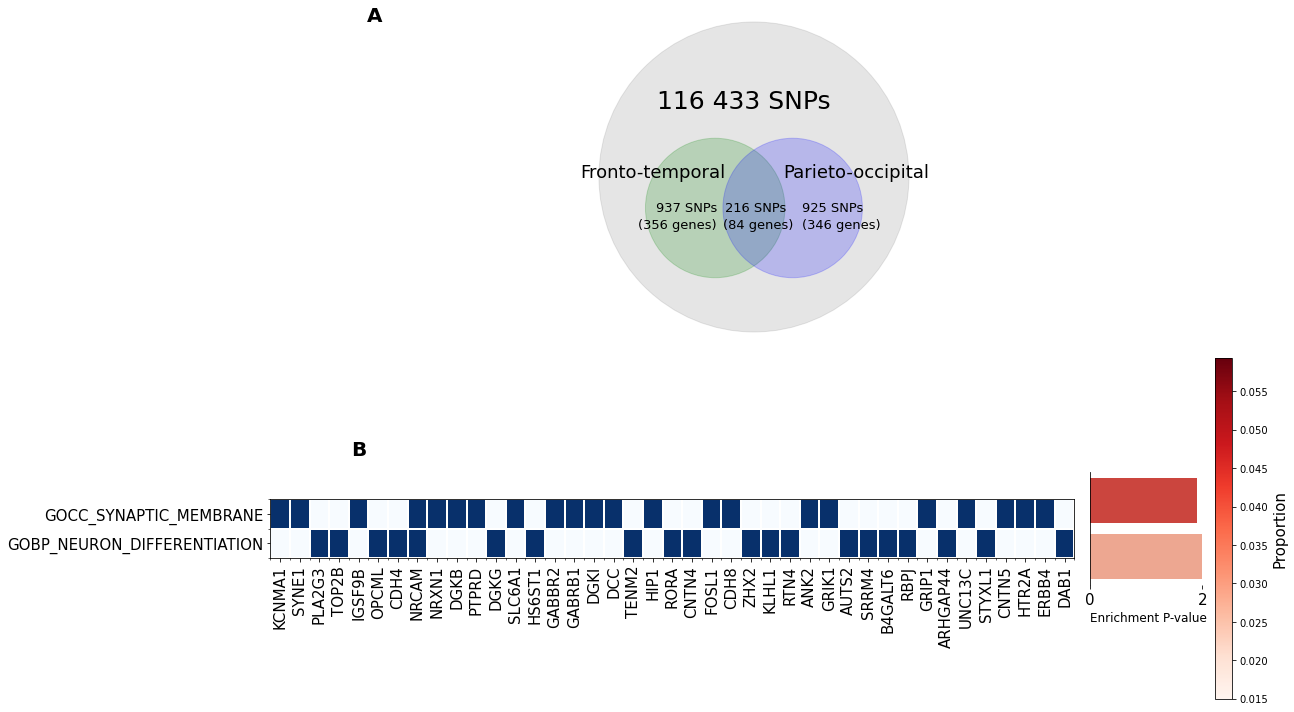

In [153]:
heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(gene_set_table=specific_results,top=100,genes_list_column='genes_names')
fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2,8,width_ratios=[1,1,1,1,6,1,1,1])

circle_plot = fig.add_subplot(gs[0,:])

ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax = ax_heatmap)
ax_heatmap.set_aspect(1.5)
ax_heatmap.tick_params('y',rotation=0)
ax_heatmap.tick_params('x',rotation=90)

aspect = 1
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(specific_results,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=12)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
ax_heatmap.text(0.1,2, 'B', transform=ax_heatmap.transAxes,fontweight='bold', va='top', fontsize=20)


circle1 = plt.Circle((1,1),1,color='grey',alpha=0.2)
circle2 = plt.Circle((0.75,.8),0.45,color='g',alpha=0.2)
circle3 = plt.Circle((1.25,.8),0.45,color='b',alpha=0.2)

circle_plot.add_patch(circle1)
circle_plot.add_patch(circle2)
circle_plot.add_patch(circle3)
# circle_plot.text(0.3,0.75, 'PRS ${P_{T}=0.05}$', transform=circle_plot.transAxes, fontsize=30, fontweight='bold')
circle_plot.text(0.4,0.7, '116 433 SNPs', transform=circle_plot.transAxes, fontsize=25)
circle_plot.text(0.32,0.5, 'Fronto-temporal', transform=circle_plot.transAxes, fontsize=18)
circle_plot.text(0.53,0.5, 'Parieto-occipital', transform=circle_plot.transAxes, fontsize=18)

circle_plot.text(0.399,0.4, '937 SNPs', transform=circle_plot.transAxes, fontsize=13)
circle_plot.text(0.38,0.35, '(356 genes)', transform=circle_plot.transAxes, fontsize=13)

circle_plot.text(0.47,0.4, '216 SNPs', transform=circle_plot.transAxes, fontsize=13)
circle_plot.text(0.468,0.35, '(84 genes)', transform=circle_plot.transAxes, fontsize=13)

circle_plot.text(0.55,0.4, '925 SNPs', transform=circle_plot.transAxes, fontsize=13)
circle_plot.text(0.55,0.35, '(346 genes)', transform=circle_plot.transAxes, fontsize=13)

circle_plot.axis('equal')
circle_plot.text(0.1,1, 'A', transform=circle_plot.transAxes,fontweight='bold', va='top', fontsize=20)

circle_plot.set_axis_off()

plt.tight_layout()
fig.savefig('../../dataset/preprocessed_dataset/asd/output_plot/gene_set_enrichment.pdf')